In [5]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader

### Load in data

*Change these - I'm not uploading the data to our repo*
If we want to be fancy we can set a function up to pull the data directly from google drive

In [64]:
ROOT = "/home/nselman/ml/drug-review-nlp"
PATH_TO_TSV = f"{ROOT}/drugsComTrain_raw.tsv"


In [20]:
df = pd.read_csv(PATH_TO_TSV, header=0, delimiter='\t', index_col=0, parse_dates=['date'])

Interpolate null conditions with Not Entered

In [34]:
df.loc[df['condition'].isna(), 'condition'] = 'Not Entered'

NO MORE NULLS!

In [35]:
df.isna().sum()

drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

### Bucket the ratings into (Positive, Neutral, Negative)

array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

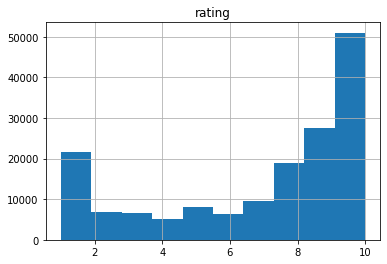

In [38]:
df.hist(column='rating')

In [40]:
df['rating'].describe()

count    161297.000000
mean          6.994377
std           3.272329
min           1.000000
25%           5.000000
50%           8.000000
75%          10.000000
max          10.000000
Name: rating, dtype: float64

Breaking our dataset into the following buckets:
- Negative: 0-3
- Neutral: 4-6
- Positive: 7-10

Positive could be divided in to 7-8, 9-10 since people based on knowledge of how reviews are given, there seems to be a meaningful difference

In [41]:
df['rating_category'] = 'Postive'
df.loc[df['rating'] < 7, 'rating_category'] = 'Neutral'
df.loc[df['rating'] < 4, 'rating_category'] = 'Negative'

### *Important Thing to Consider*
*Rating categories are very imbalanced - let's ask Amitabh if there's some sort of a strategy that will balance the types that our algorithm will see during training.  Right now our model would minimized loss by predictive every review as positive since mini batches are likely to be nearly all positive.  Ideally we'd want each mini batch to contain examples belonging to every rating category.*


In [43]:
df['rating_category'].value_counts()

Postive     106866
Negative     35063
Neutral      19368
Name: rating_category, dtype: int64

### Convert Usefulness to Count/Day

Since usefulness ratings are a function of how long the review has existed, this converts it to usefulness/day

Assumption:
- All reviews were scraped on the same day AND this is the same date as the most recent review
- The only factor that is correlated with the number of likes is the text of the review. (this assumption is particularly suspect because reviews that already have likes are more likely to be seen and thus may be more likely to be liked again).

In [73]:
max_date = df['date'].max()
print(max_date)

2017-12-12 00:00:00


In [58]:
(max_date - df['date']).dt.days

206461    2032
95260     2786
92703     2920
138000     770
35696      380
          ... 
191035     926
127085    2233
187382    1368
47128      815
215220    1095
Name: date, Length: 161297, dtype: int64

In [61]:
df['useful_daily'] = df['usefulCount'] / ((max_date - df['date']).dt.days + 1) # +1 to avoid any division issues

Write dat shit

In [70]:
df.to_csv(f'{ROOT}/clean-train.csv', index=False)

### Create Dataset Object

In [72]:
CLEAN_DATA_FILE = f'{ROOT}/clean-train.csv'
data = pd.read_csv(CLEAN_DATA_FILE, header=0, parse_dates=['date'])
data.dtypes

drugName                   object
condition                  object
review                     object
rating                    float64
date               datetime64[ns]
usefulCount                 int64
rating_category            object
useful_daily              float64
dtype: object

In [131]:
class DrugReviewDataset(Dataset):
    def __init__(self, csv_file):
        """
        the following are assumed about csv_file:
            - headers are in first row
            - there is a column called 'date'
            - there is a column called 'review' which contains the text data
        """
        self.pandas_df = pd.read_csv(csv_file, header=0, parse_dates=['date'])
        self.__target = None
        self.text_col = 'review'

    
    @property
    def target(self):
        return self.__target
    
    @target.setter
    def target(self, new_target):
        if new_target in self.pandas_df.columns and new_target != 'review':
            self.__target = new_target
        else:
            print("invalid target - target can't be 'review' or a column that's not in the pandas df")
            raise ValueError
            
        
    def __len__(self):
        return len(self.pandas_df)
    
    def __getitem__(self, idx):
        """
        idx can be a list or tensor if integers
        """
        if not self.target:
            print("set a target before trying to get items bro.  use dataset.target = 'target_name'")
            raise LookupError
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        example_target = self.pandas_df.loc[idx, [self.target]].item()
        example_review = self.pandas_df.loc[idx, [self.text_col]].item()
            
        example = (example_target, example_review)
        
        return example

In [132]:
ds = DrugReviewDataset(CLEAN_DATA_FILE)

In [133]:
ds.target = 'rating_category'
for i in range(3):
    print(ds[i])

('Postive', '"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"')
('Postive', '"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."')
('Neutral', '"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other sid

### Dataloader

In [134]:
dataloader = DataLoader(ds, batch_size=10, shuffle=True)

In [138]:
for i, (tar, rev) in enumerate(dataloader):
    print(tar)
    if i == 3:
        break

('Postive', 'Postive', 'Postive', 'Neutral', 'Postive', 'Postive', 'Postive', 'Postive', 'Postive', 'Negative')
('Negative', 'Postive', 'Negative', 'Postive', 'Negative', 'Neutral', 'Postive', 'Neutral', 'Postive', 'Postive')
('Negative', 'Negative', 'Postive', 'Negative', 'Postive', 'Postive', 'Postive', 'Neutral', 'Neutral', 'Postive')
('Neutral', 'Negative', 'Postive', 'Postive', 'Neutral', 'Postive', 'Postive', 'Postive', 'Negative', 'Postive')


In [117]:
pwd

'/home/nselman/ml'